# Purposes of this document

the BMI3D implements clda in the form of learner and updater with
1. learner collect training samples that are paired from collected features and estiamted intentions. 
2. the updater is then used to update the decoder specifically Kalman filter's observation matrix. 

in this experiment, we confirm our understanding that
with different batch lengths, 
our updater actually   observation matrix. 

the main variables in this loop is 
1. learner's batch size
2. and the updater's rho which controls the amount of mixing between old and new decoder parameters. 



we are gonna set up with three exps with identical trial sequences. 
3. 1000 sample lengths. 

in the end, 
we will demonstrate the mismatch through
1. the rewarded trials and the reward trial rate. 
2. qualitative comparisions of trajectories. 
3. the tuning directions of C. and the tracking performance using correlation coefficients

# General experimental set up

24 out of 24 
need measure performance as a function time. 
how many samples per trial?
run simulations longer.
how many updates are happening? the rates are the same withtin the tests, but run at different periods of time. 



In [1]:
import numpy as np


RHO = 0.5
batch_sizes = [10]
exp_conds = [f'batch length:{b} s' for b in batch_sizes]


# set up assist level
assist_level = (0.1, 0)


UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)

print(f'the updater half_life is {UPDATER_HALF_LIFE}')

the updater half_life is 1.0


In [2]:
NUM_EXP = len(exp_conds) # how many experiments we are running. 
#generate task params
N_TARGETS = 8
N_TRIALS = 8

# setting up the simulation components

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

In [3]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom, SimCosineTunedEnc,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train

from weights import replace_kalman_filter
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


##  set up trial seq

In [4]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]

##  simulation encoder decoder setup

In [5]:
#clda on random 
DECODER_MODE = 'random' # random 
ENCODER_TYPE = 'cosine_tuned_encoder'
LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'toy')

features.simulation_features: get_enc_setup has a tuning_level of 1 



## from the setup options, set up experiment

In [6]:


#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow
feats = []

#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
if ENCODER_TYPE == 'cosine_tuned_encoder' :
    feats.append(SimCosineTunedEnc)
    print(f'{__name__}: selected SimCosineTunedEnc\n')
    
    
   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')
    
    
#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)




#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C
    d['batch_size'] = batch_sizes[i]
    
    kwargs_exps.append(d)

kwargs_exps

__main__: selected SimCosineTunedEnc

__main__: set base class 
__main__: selected SimKFDecoderRandom 



[{'assist_level': (0.1, 0),
  'sim_C': array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.]]),
  'batch_size': 10}]

## seed the exp

In [7]:
np.random.seed(0)

## make our experiment class

In [8]:
#spawn the task
Exp = experiment.make(base_class, feats=feats)


metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]


# creat experiments with different C batch lengths

## create exps

In [9]:
exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)


features.simulation_features.SimIntentionLQRController: LQRController used 


 features.simulation_features.SimFeedbackLearner: start to create a sim leaner with a batchsize of 10
features.simulation_features.SimSmoothBatch: rho in this simulation is  0.9885140203528962

finished executing Experiment.__init__


In [10]:
for e in exps: e.init()


SimCosineTunedEnc SSM: State space: ['hand_px', 'hand_py', 'hand_pz', 'hand_vx', 'hand_vy', 'hand_vz', 'offset'] 

neural encoder init function  <BMIControlMultiNoWindow(Thread-4, initial)>
features.simulation_features: added tracking of K matrix
features.simulation_features: batch size is 10
Reset states for learner: 
[]
Done states for learner: 
[]

features.simulation_features.SimFeedbackLearner: flip the self.learn_flag to true
features.simulation_features.SimFeedbackLearner: succussfully created a feedback controller learner


SimSmoothBatch: created an updater with a batch time of 1 and a half_life of 60 



## create the three batch sizes

In [11]:
#before
for i,e in enumerate(exps):
    print(e.batch_size)

10


## check the Kalman filter before training

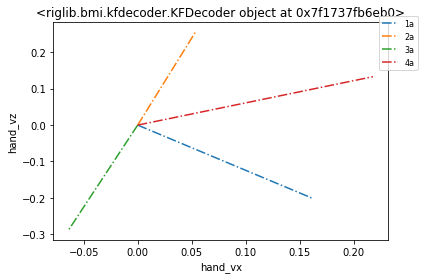

In [12]:
for e in exps:
    e.decoder.plot_K()

# assemble into a complete loop

In [13]:
#make this into a loop

def run_exp_loop(exp,  **kwargs):
        # riglib.experiment: line 597 - 601
    #exp.next_trial = next(exp.gen)
    # -+exp._parse_next_trial()np.arraynp.array


    # we need to set the initial state
    # per fsm.run:  line 138


    # Initialize the FSM before the loop
    exp.set_state(exp.state)
    
    finished_trials = exp.calc_state_occurrences('wait')
    print(f'finished: {finished_trials}')


    while exp.state is not None:

        # exp.fsm_tick()

        ### Execute commands#####
        exp.exec_state_specific_actions(exp.state)

        ###run the bmi loop #####
        # _cycle

        # bmi feature extraction, eh
        #riglib.bmi: 1202
        feature_data = exp.get_features()

        # Determine the target_state and save to file
        current_assist_level = exp.get_current_assist_level()
        target_state = exp.get_target_BMI_state(exp.decoder.states)

        # Determine the assistive control inputs to the Decoder
        #update assistive control level
        exp.update_level()
        if np.any(current_assist_level) > 0:
            current_state = exp.get_current_state()

            if target_state.shape[1] > 1:
                assist_kwargs = exp.assister(current_state, 
                                             target_state[:,0].reshape(-1,1), 
                                             current_assist_level, mode= exp.state)
            else:
                assist_kwargs = exp.assister(current_state, 
                                              target_state, 
                                              current_assist_level, 
                                              mode= exp.state)

            kwargs.update(assist_kwargs)
            
        

        # decode the new features
        # riglib.bmi.bmiloop: line 1245
        neural_features = feature_data[exp.extractor.feature_type]

        # call decoder.
        #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
        neural_obs = neural_features
        learn_flag = exp.learn_flag
        task_state = exp.state

        n_units, n_obs = neural_obs.shape
        # If the target is specified as a 1D position, tile to match
        # the number of dimensions as the neural features
        if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
            target_state = np.tile(target_state, [1, n_obs])

        decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
        update_flag = False

        for k in range(n_obs):
            neural_obs_k = neural_obs[:, k].reshape(-1, 1)
            target_state_k = target_state[:, k]

            # NOTE: the conditional below is *only* for compatibility with older Carmena
            # lab data collected using a different MATLAB-based system. In all python cases,
            # the task_state should never contain NaN values.
            if np.any(np.isnan(target_state_k)):
                task_state = 'no_target'

            #################################
            # Decode the current observation
            #################################
            decodable_obs, decode = exp.bmi_system.feature_accumulator(
                neural_obs_k)
            if decode:  # if a new decodable observation is available from the feature accumulator
                prev_state = exp.bmi_system.decoder.get_state()

                exp.bmi_system.decoder(decodable_obs, **kwargs)
                # Determine whether the current state or previous state should be given to the learner
                if exp.bmi_system.learner.input_state_index == 0:
                    learner_state = exp.bmi_system.decoder.get_state()
                elif exp.bmi_system.learner.input_state_index == -1:
                    learner_state = prev_state
                else:
                    print(("Not implemented yet: %d" %
                           exp.bmi_system.learner.input_state_index))
                    learner_state = prev_state

                if learn_flag:
                    exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                    ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

            decoded_states[:, k] = exp.bmi_system.decoder.get_state()

            ############################
            # Update decoder parameters
            ############################
            if exp.bmi_system.learner.is_ready():
                batch_data = exp.bmi_system.learner.get_batch()
                batch_data['decoder'] = exp.bmi_system.decoder
                kwargs.update(batch_data)
                exp.bmi_system.updater(**kwargs)
                exp.bmi_system.learner.disable()

            new_params = None  # by default, no new parameters are available
            if exp.bmi_system.has_updater:
                new_params = copy.deepcopy(exp.bmi_system.updater.get_result())

            # Update the decoder if new parameters are available
            if not (new_params is None):
                exp.bmi_system.decoder.update_params(
                    new_params, **exp.bmi_system.updater.update_kwargs)
                new_params['intended_kin'] = batch_data['intended_kin']
                new_params['spike_counts_batch'] = batch_data['spike_counts']

                exp.bmi_system.learner.enable()
                update_flag = True

                # Save new parameters to parameter history
                exp.bmi_system.param_hist.append(new_params)



        # saved as task data
        # return decoded_states, update_flag
        tmp = decoded_states
        exp.task_data['internal_decoder_state'] = tmp

        # reset the plant position
        # @riglib.bmi.BMILoop.move_plant  line:1254
        exp.plant.drive(exp.decoder)

        # check state transitions and run the FSM.
        current_state = exp.state

        # iterate over the possible events which could move the task out of the current state
        for event in exp.status[current_state]:
            # if the event has occurred
            if exp.test_state_transition_event(event):
                # execute commands to end the current state
                exp.end_state(current_state)

                # trigger the transition for the event
                exp.trigger_event(event)

                # stop searching for transition events (transition events must be
                # mutually exclusive for this FSM to function properly)
                break

        # sort out the loop params.
        # inc cycle count
        exp.cycle_count += 1

        # save target data as was done in manualControlTasks._cycle
        exp.task_data['target'] = exp.target_location.copy()
        exp.task_data['target_index'] = exp.target_index

        #done in bmi:_cycle after move_plant
        exp.task_data['loop_time'] = exp.iter_time()


        #fb_controller data
        exp.task_data['target_state'] = target_state

        #encoder data
        #input to this is actually extractor
        exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))

        #actually output
        exp.task_data['spike_counts'] = feature_data['spike_counts']


        #save the decoder_state
        #from BMILoop.move_plant
        exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))
        
        #save bmi_data
        exp.task_data['update_bmi'] = update_flag


        # as well as plant data.
        plant_data = exp.plant.get_data_to_save()
        for key in plant_data:
            exp.task_data[key] = plant_data[key]

        # clda data handled in the above call.

        # save to the list hisory of data.
        exp.task_data_hist.append(exp.task_data.copy())
        
        #print out the trial update whenever wait count changes, alright. 
        if finished_trials != exp.calc_state_occurrences('wait'):
            finished_trials = exp.calc_state_occurrences('wait')
            print(f'finished trials :{finished_trials} with a current assist level of {exp.get_current_assist_level()}')


    if exp.verbose:
        print("end of FSM.run, task state is", exp.state)
    
    


In [14]:
for i,e in enumerate(exps):
    run_exp_loop(e, **kwargs_exps[i])
    print(f'Finished running  {exp_conds[i]}')

runseq
finished: 1
assist_level:  0.1


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


assist_level:  0.09
finished trials :2 with a current assist level of 0.08154166666666668
assist_level:  0.08
assist_level:  0.07
finished trials :3 with a current assist level of 0.06313888888888888
assist_level:  0.06
assist_level:  0.05
finished trials :4 with a current assist level of 0.04471944444444445
assist_level:  0.04000000000000001
assist_level:  0.030000000000000013
finished trials :5 with a current assist level of 0.026300000000000004
assist_level:  0.01999999999999999
assist_level:  0.009999999999999995
finished trials :6 with a current assist level of 0.007880555555555543
assist_level at final value after 0 successful trials
finished trials :7 with a current assist level of 0.0
finished trials :8 with a current assist level of 0.0
finished trials :9 with a current assist level of 0.0
end of FSM.run, task state is None
Finished running  batch length:10 s


# Preprocess the data for loading

In [15]:
for e in  exps: print(e.calc_state_occurrences('reward'))

0


## declare defs and conventions

In [16]:
FRAME_RATE = 60
INT_WINDOW_TIME = 10 # s for looking at sample raw data

# some conventions as we go down the loop
X_VEL_STATE_IND = 3
Y_VEL_STATE_IND = 5
X_POS_STATE_IND = 0
Y_POS_STATE_IND = 2

state_indices = [X_POS_STATE_IND,
                 Y_POS_STATE_IND,
                 X_VEL_STATE_IND,
                 Y_VEL_STATE_IND]
state_names = ['x pos ', 'y pos', 'x vel', 'y vel']


INT_WIN_SAMPLES = INT_WINDOW_TIME * FRAME_RATE



## Quick look at the cursor trajectories

In [17]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
len(task_data_hist_np_all)
task_data_hist_np_all[0].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (4, 1)), ('K', '<f8', (7, 4)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (4, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

## segment data into trials

In [18]:
def filter_state(state_log:list, state_to_match:str)->list:
    '''#set axis limits of plot (x=0 to 20, y=0 to 20)
plt.axis([0, 20, 0, 20])
plt.axis("equal")

    state_log: a list of tuples (state:string, start_time: float)
    state_to_watch
    
    returns a list of element type
    '''
    
    return list(filter(lambda k: k[0] == state_to_match, state_log) )

def calc_inter_wait_times(wait_log: list)-> list:
    """
    state_log: a list of tuples ("wait", start_time: float)
    return a list of tuples: ("wait", start_time: float, diff_time)
    """
    wait_log_with_diff = list()
    for i, wait_state in enumerate(wait_log):
        if i == len(wait_log)-1: #there is nothing to subtract, just put zero.
            wait_log_with_diff.append((wait_state[1],  0))
            
        else:
            finish_time = wait_log[i+1][1]
            wait_log_with_diff.append((wait_state[1],  finish_time - wait_state[1]))
    
    return np.array(wait_log_with_diff[:-1])

In [19]:
state_logs = [e.state_log for e in exps]


In [20]:
STATE_CUT_NAME =  'wait'
#get the state logs
wait_logs = [filter_state(s, STATE_CUT_NAME) for s in state_logs]

inter_wait_times = [calc_inter_wait_times(w) for w in wait_logs]
#this has both start times 

Text(0, 0.5, 'Trial time (s)')

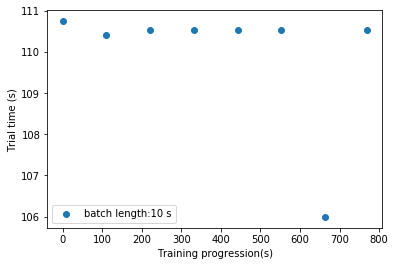

In [21]:


for i in inter_wait_times:
    plt.scatter(i[:,0], i[:,1])

plt.legend(exp_conds)
plt.xlabel('Training progression(s)')
plt.ylabel('Trial time (s)')

In [22]:
wait_time = inter_wait_times[0]
task_data_hist_np = task_data_hist_np_all[0]
FRAME_RATE


60

In [23]:
def sort_trials(wait_time:list, 
                target_seq:list,
                task_data_hist_np:dict, 
                dict_keys, FRAME_RATE = 60):
    trial_dict = list()
    
    for i,row in enumerate(wait_time):
        start_time = row[0]
        inter_wait_time = row[1]

        start_sample = int(start_time * FRAME_RATE)
        inter_wait_sample = int(inter_wait_time * FRAME_RATE)
        stop_sample = start_sample + inter_wait_sample

        single_trial_dict = dict()

        for k in dict_keys:
            
            requested_type_data = np.squeeze(task_data_hist_np[k])
            single_trial_dict[k] =  requested_type_data[start_sample:stop_sample,
                                                       :]
        #add more info
        single_trial_dict['start_time'] = row[0]
        single_trial_dict['inter_wait_time'] = row[1]
        
        #add target info
        single_trial_dict['targets'] = target_seq[i]

        #add the dictionary to the list
        trial_dict.append(single_trial_dict)
        
    return trial_dict



In [24]:


trial_dicts_all = []
dict_keys = ['cursor', 'decoder_state', 'ctrl_input']

for i in range(NUM_EXP):
    wait_time = inter_wait_times[i]
    task_data_hist_np = task_data_hist_np_all[i]
    
    trial_dict_0 = sort_trials(wait_time, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)

len(trial_dicts_all)

1

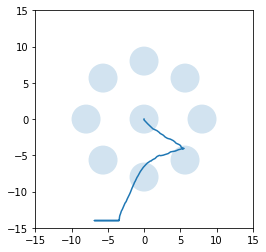

In [25]:
n_roi_trials = 0
unique_targets =  np.unique(target_seq, axis = 0)


X_CURSOR = 0
Z_CURSOR = 2
CIRCL_ALPHA = 0.2



RANGE_LIM =  15
figure, axes = plt.subplots() 

axes.set_xlim(-RANGE_LIM, RANGE_LIM)
axes.set_ylim(-RANGE_LIM, RANGE_LIM)

CIRCLE_RADIUS = exps[0].target_radius

#plot the targets

#plot the origin

cc = plt.Circle((0,0 ), 
            radius = CIRCLE_RADIUS,
            alpha = CIRCL_ALPHA)

axes.add_artist( cc ) 

for origin_t in unique_targets:
    origin = origin_t[0]
    t = origin_t[1]

    cc = plt.Circle((t[X_CURSOR],t[Z_CURSOR] ), 
                    radius = CIRCLE_RADIUS,
                    alpha = CIRCL_ALPHA)
                     
    axes.set_aspect( 1 ) 
    axes.add_artist( cc ) 
    
    
for trial_dict in trial_dicts_all:
    
    sample_trial = trial_dict[n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    
    axes.plot(trial_cursor_trajectory[:, X_CURSOR], 
             trial_cursor_trajectory[:, Z_CURSOR])
    



In [26]:
print('finished trials ')

for i,e in  enumerate(exps): 
    reward_num = e.calc_state_occurrences('reward')
    print(f'{exp_conds[i]}: {reward_num} out of {N_TRIALS}')

finished trials 
batch length:10 s: 0 out of 8


In [27]:
trial_dicts_all[0][-1]

{'cursor': array([[-14.  ,   0.  ,  14.  ],
        [-14.  ,   0.  ,  14.  ],
        [-14.  ,   0.  ,  14.  ],
        ...,
        [ 14.  ,   0.  ,  -7.65],
        [ 14.  ,   0.  ,  -7.51],
        [ 14.  ,   0.  ,  -7.51]]),
 'decoder_state': array([[-14.  ,   0.  ,  14.  , ...,   0.  ,   0.  ,   1.  ],
        [-14.  ,   0.  ,  14.  , ...,   0.  ,   0.  ,   1.  ],
        [-14.  ,   0.  ,  14.  , ...,   0.  ,   0.  ,   1.  ],
        ...,
        [ 14.  ,   0.  ,  -7.65, ...,   0.  ,  -4.1 ,   1.  ],
        [ 14.  ,   0.  ,  -7.51, ...,   0.  ,  -2.1 ,   1.  ],
        [ 14.  ,   0.  ,  -7.51, ...,   0.  ,  -2.1 ,   1.  ]]),
 'ctrl_input': array([[-14.  ,   0.  ,  14.  , ...,   0.  , -12.04,   1.  ],
        [-14.  ,   0.  ,  14.  , ...,   0.  , -12.04,   1.  ],
        [-14.  ,   0.  ,  14.  , ...,   0.  , -12.04,   1.  ],
        ...,
        [ 14.  ,   0.  ,  -8.06, ...,   0.  ,   4.51,   1.  ],
        [ 14.  ,   0.  ,  -8.06, ...,   0.  ,   4.51,   1.  ],
        [ 14.  ,   

### examine the tuning curves

steady state tuning curves:


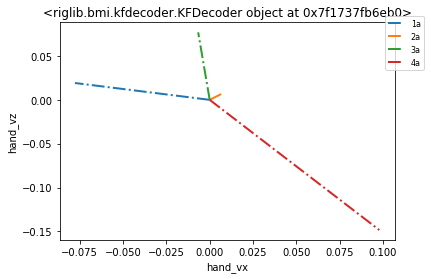

In [28]:
print('steady state tuning curves:')

for i,e in enumerate(exps):
    e.decoder.plot_C()

# CLDA updates

## clda update frequencies

In [29]:

clda_params_all = [np.array(e.bmi_system.param_hist) for e in exps]

for c in clda_params_all:
    print(f'did clda for {len(c)} times')

did clda for 879 times


In [30]:
update_bmi_all = np.squeeze(task_data_hist_np_all[0]['update_bmi'])

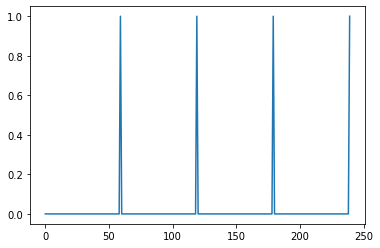

In [31]:
plt.plot(update_bmi_all[:240])

In [32]:
clda_params = clda_params_all[0]

clda_params_dict = dict()
for param_key in clda_params[0].keys():
    clda_params_dict[param_key] = np.array([ record_i[param_key] for record_i in clda_params])



clda_params_dict.keys()

dict_keys(['kf.C', 'kf.Q', 'kf.C_xpose_Q_inv_C', 'kf.C_xpose_Q_inv', 'mFR', 'sdFR', 'rho', 'intended_kin', 'spike_counts_batch'])

## clda K matrix

In [33]:
kf_C = clda_params_dict['kf.C']

In [34]:
print('K matrix before:')
print(kf_C[0,:,:])
print('K matrix after:')
print(kf_C[-1,:,:])

K matrix before:
[[ 0.    0.    0.    2.22  0.   -0.97  0.94]
 [ 0.    0.    0.    0.14  0.    0.75  0.12]
 [ 0.    0.    0.   -0.2   0.   -0.84 -2.52]
 [ 0.    0.    0.    2.24  0.    0.05 -0.19]]
K matrix after:
[[ 0.    0.    0.   -0.08  0.    0.02 -0.1 ]
 [ 0.    0.    0.    0.01  0.    0.01  0.24]
 [ 0.    0.    0.   -0.01  0.    0.08 -0.65]
 [ 0.    0.    0.    0.1   0.   -0.15 -3.28]]


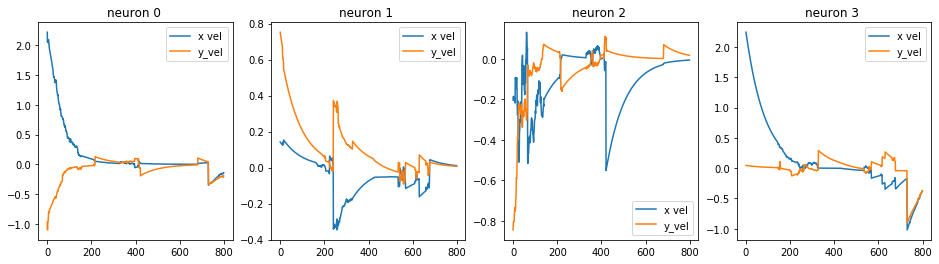

In [35]:
N_CLDA_ROI_TIME = 800

FIGURE_SIZE = (2,10)

N_NEURONS

f, axs = plt.subplots(1,N_NEURONS,figsize=(16,4))

for i in range(N_NEURONS):
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, X_VEL_STATE_IND]))
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, Y_VEL_STATE_IND]))
    axs[i].legend(['x vel', 'y_vel'])
    axs[i].set_title(f'neuron {i} ')



In [36]:
exps[0].encoder.C

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.]])

## examine training batches

In [37]:
spike_counts_batch = clda_params_dict['spike_counts_batch'] 
intended_kin = clda_params_dict['intended_kin']

In [38]:
training_sample_point = 2

print('intended kinematics:')
print(intended_kin[training_sample_point])

print('spike counts:')
print(spike_counts_batch[training_sample_point])

print('trained KF C matrix:')
print(kf_C[training_sample_point])

intended kinematics:
[[ 1.18  1.23  1.29  1.35  1.4   1.47  1.52  1.57  1.63  1.68]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-1.35 -1.37 -1.39 -1.43 -1.45 -1.49 -1.5  -1.52 -1.56 -1.57]
 [ 6.    5.88  5.84  5.86  5.74  5.76  5.64  5.59  5.62  5.5 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.83  1.01  1.06  0.99  1.1   1.04  1.16  1.19  1.11  1.22]
 [ 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.  ]]
spike counts:
[[0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
trained KF C matrix:
[[ 0.    0.    0.    2.09  0.   -0.99  1.39]
 [ 0.    0.    0.    0.14  0.    0.74  0.12]
 [ 0.    0.    0.   -0.18  0.   -0.8  -2.56]
 [ 0.    0.    0.    2.19  0.    0.04 -0.18]]
